In [ ]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [ ]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)


In [ ]:
anchor = tf.data.Dataset.list_files(f'{ANC_PATH}/*.jpg').take(50)
positive = tf.data.Dataset.list_files(f'{POS_PATH}/*.jpg').take(50)
negative = tf.data.Dataset.list_files(f'{NEG_PATH}/*.jpg').take(50)
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data/anchor/3de5cb2e-4f07-11ef-9507-b48c9d5129fd.jpg'


In [ ]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img


In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()
exampple = samples.next()
exampple

(b'data/anchor/3fe1f675-4f07-11ef-ba93-b48c9d5129fd.jpg',
 b'data/positive/45fa0914-4f07-11ef-b325-b48c9d5129fd.jpg',
 1.0)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')
embedding = make_embedding()

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        input_tensor = tf.convert_to_tensor(input_embedding)
        validation_tensor = tf.convert_to_tensor(validation_embedding)
        # Calculate L1 distance
        return tf.math.abs(input_tensor - validation_tensor)

    # def compute_output_shape(self, input_shape):
    #     return input_shape[0]
l1 = L1Dist()

In [ ]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_model = make_siamese_model()

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


In [ ]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y


array([0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    label = tf.expand_dims(label, axis=-1)  # Add an extra dimension to match model output
    return preprocess(input_img), preprocess(validation_img), label


In [ ]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)

        # Reshape yhat to match y
        yhat = tf.squeeze(yhat)  # Remove single-dimensional entries from the shape of yhat

        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

def preprocess_twin(input_img, validation_img, label):
    label = tf.expand_dims(label, axis=-1)  # Add an extra dimension to match model output
    return preprocess(input_img), preprocess(validation_img), label

# Train function
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

EPOCHS = 50
train(train_data, EPOCHS)



 Epoch 1/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/stepTensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step

 Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step

 Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step

 Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step

 Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step

 Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step

 Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step

 Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step

 Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step

 Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step

 Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step

 Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step

 Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step

 Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step

 Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[[2.4170490e-07],
        [1.7741848e-05],
        [9.9999976e-01],
        [1.0000000e+00],
        [9.9972123e-01],
        [9.9996376e-01],
        [1.0000000e+00],
        [9.9998188e-01],
        [7.9062611e-06],
        [4.3488168e-07],
        [1.0000000e+00],
        [2.1722988e-05],
        [1.0000000e+00],
        [1.8919336e-05],
        [9.9987566e-01],
        [9.9999452e-01]]], dtype=float32)

In [ ]:
y_hat = (y_hat > 0.5).astype(int)

# Print the binary predictions
print(y_hat)

[[[0]
  [0]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [0]
  [0]
  [1]
  [0]
  [1]
  [0]
  [1]
  [1]]]


In [ ]:
y_true

array([0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.],
      dtype=float32)

In [ ]:
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

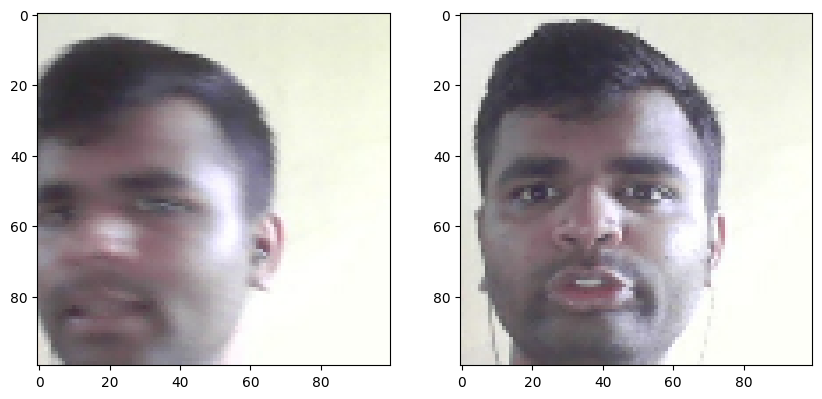

In [ ]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

In [ ]:
siamese_model.save('siamesemodel.h5')

In [ ]:
L1Dist

__main__.L1Dist

In [ ]:
model = tf.keras.models.load_model('siamesemodel.h5',
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [ ]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


array([[[2.4170490e-07],
        [1.7741848e-05],
        [9.9999976e-01],
        [1.0000000e+00],
        [9.9972123e-01],
        [9.9996376e-01],
        [1.0000000e+00],
        [9.9998188e-01],
        [7.9062611e-06],
        [4.3488168e-07],
        [1.0000000e+00],
        [2.1722988e-05],
        [1.0000000e+00],
        [1.8919336e-05],
        [9.9987566e-01],
        [9.9999452e-01]]], dtype=float32)

'application_data/input_image/input_image.jpg'

In [ ]:
# for image in os.listdir(os.path.join('application_data', 'verification_images')):
#     validation_img = os.path.join('application_data', 'verification_images', image)
#     print(validation_img)

FileNotFoundError: [Errno 2] No such file or directory: 'application_data/verification_images'

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array, load_img

def preprocess(img_path):
    img = load_img(img_path, target_size=(100, 100))  # Adjust size as needed
    img = img_to_array(img)
    img = img / 255.0  # Normalize image
    return img

def verify(model, verification_threshold):
    # Base image path and preprocessing
    base_image_path = os.path.join('application_data', 'base_image', "base_image.jpg")
    base_image = preprocess(base_image_path)

    # Store results
    results = []

    # Loop through each input image
    input_images_path = os.path.join('application_data', 'input_images')
    for iimage in os.listdir(input_images_path):
        input_img_path = os.path.join(input_images_path, iimage)
        input_img = preprocess(input_img_path)

        # Predict similarity
        result = model.predict([np.expand_dims(base_image, axis=0), np.expand_dims(input_img, axis=0)])
        similarity = result[0][0]
        verified = similarity > verification_threshold

        # Log the result
        similarity_value = float(similarity)  # Extract the float value
        print(f'Input Image: {iimage}, Similarity: {similarity_value:.2f}, Verified: {"Match" if verified else "No Match"}')

        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Display base image
        base_img_display = load_img(base_image_path)
        axs[0].imshow(base_img_display)
        axs[0].axis('off')
        axs[0].set_title('Base Image')

        # Display input image
        input_img_display = load_img(input_img_path)
        axs[1].imshow(input_img_display)
        axs[1].axis('off')
        axs[1].set_title(f'Input Image: {iimage}\nVerified: {"Match" if verified else "No Match"}\nSimilarity: {similarity_value:.2f}')

        plt.show()

    # Return results for further processing if needed
    return results

# Example usage
# Call this function after your model is loaded and ready.
# verify(siamese_model, verification_threshold=0.5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Input Image: Yuri_Malenchenko_0002.jpg, Similarity: 0.00, Verified: No Match


<ipython-input-32-69dbdf4ac911>:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarity_value = float(similarity)  # Extract the float value


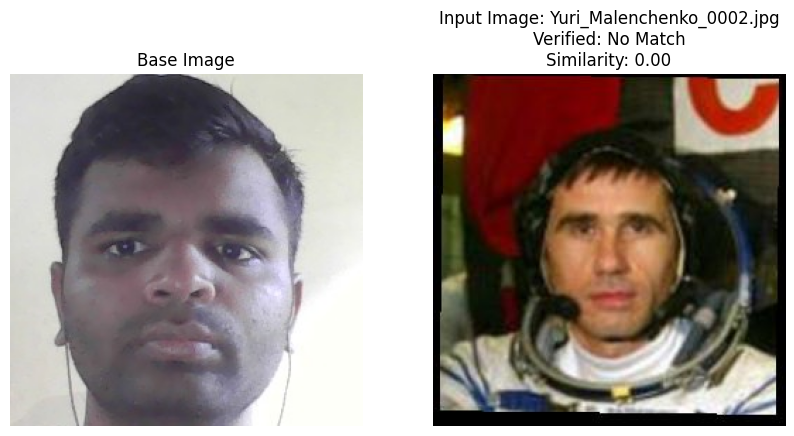

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input Image: Yao_Ming_0004.jpg, Similarity: 0.00, Verified: No Match


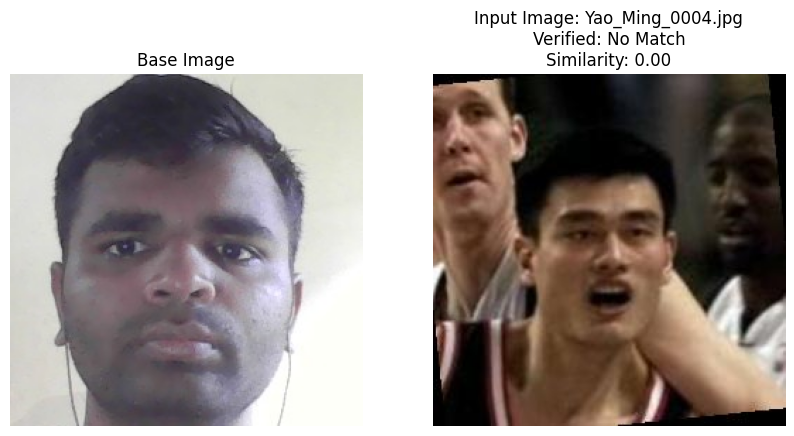

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input Image: 9c6dc187-4f07-11ef-9de4-b48c9d5129fd.jpg, Similarity: 1.00, Verified: Match


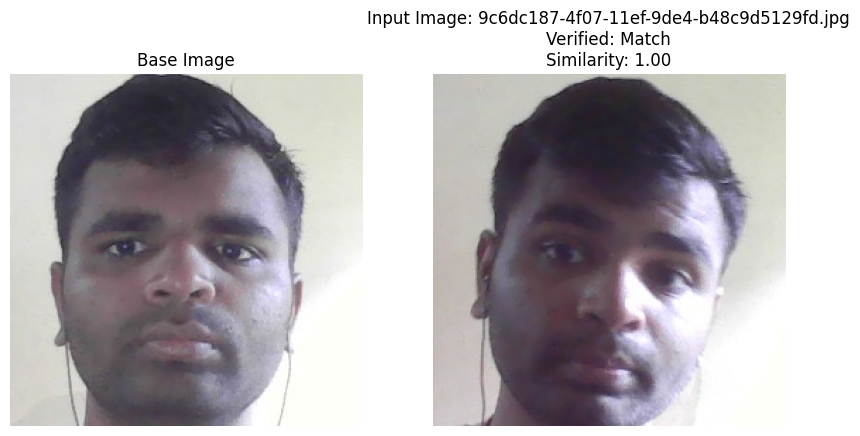

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Input Image: f3514c48-4f07-11ef-ab00-b48c9d5129fd.jpg, Similarity: 1.00, Verified: Match


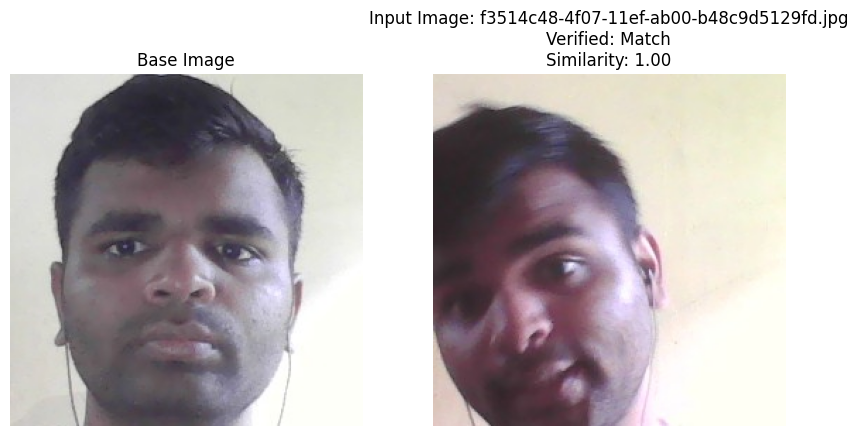

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Input Image: f3fba93e-4f07-11ef-b6f1-b48c9d5129fd.jpg, Similarity: 1.00, Verified: Match


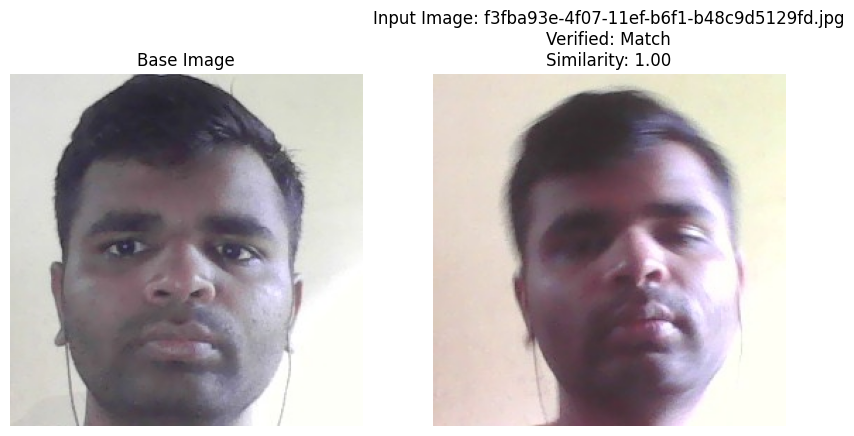

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Input Image: 45fa0914-4f07-11ef-b325-b48c9d5129fd.jpg, Similarity: 0.96, Verified: Match


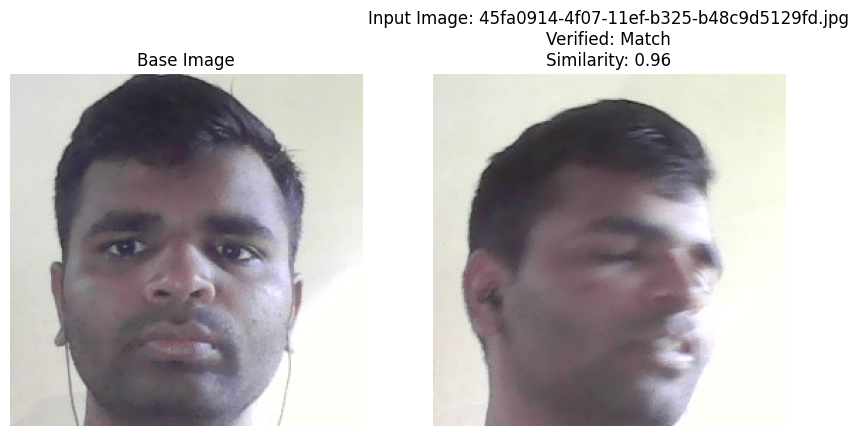

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input Image: Yuri_Malenchenko_0001.jpg, Similarity: 0.00, Verified: No Match


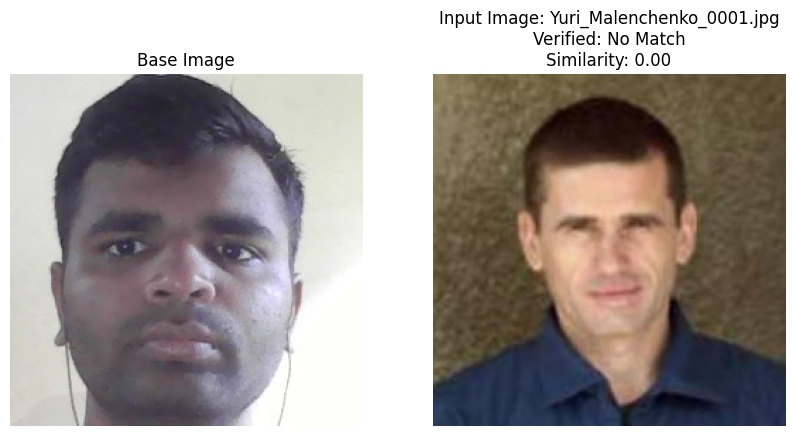

In [35]:
results = verify(model, verification_threshold=0.8)
